# srs 服务器负载测试

## 服务器配置 
- CPU 单核
- 内存 2GB

In [25]:
!pip install -i https://mirrors.aliyun.com/pypi/simple/ opencv_python

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


     ---------------------------------------- 38.2/38.2 MB 6.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import subprocess as sp
import threading
import time
import json
import requests

In [8]:
pipe_set = []
thread_set = []
isFinished = False
cpu_usage_set = []
memory_usage_set = []
netword_up_set = []
pre_kbps = {
    "srs_sample_time" : 0,
    "srs_recv_bytes" : 0
}

batch_size = 11

def get_usage_info():
    index = 1
    while  not isFinished:
        print("第",index,"次统计")
        url = "http://192.168.33.100:1985/api/v1/summaries"
        myParams = {} 
        res = requests.get(url=url, params=myParams)
        res = json.loads(res.text)
        cpu = res['data']["self"]['cpu_percent']
        mem = res['data']["self"]['mem_kbyte']
        net_in = 0
        diff = res['data']["system"]['srs_sample_time'] - pre_kbps['srs_sample_time']
        if (diff > 0) :
            net_in = (res['data']["system"]['srs_recv_bytes'] - pre_kbps['srs_recv_bytes']) * 8 / diff
            # kbps.out.srs = (data.data.system.srs_send_bytes - $scope.pre_kbps.system.srs_send_bytes) * 8 / diff;
        
        pre_kbps['srs_sample_time'] = res['data']["system"]['srs_sample_time']
        pre_kbps['srs_recv_bytes'] = res['data']["system"]['srs_recv_bytes']
        print(cpu,'\t',mem,'\t',net_in)
        cpu_usage_set.append(cpu)
        memory_usage_set.append(mem)
        netword_up_set.append(net_in)
        time.sleep(1)
        index = index + 1

def start_streaming(pipe_set, batch_size):
    cap = cv2.VideoCapture('e:\jzl1.mp4')  
    for i in range(batch_size):
        rtmpUrl = 'rtmp://192.168.33.100/live/livestream'+str(i)
        fps = float(cap.get(5))
        # command = ['ffmpeg',
        #                '-y', '-an',
        #                '-f', 'rawvideo',
        #                '-vcodec', 'rawvideo',
        #                '-pix_fmt', 'bgr24',
        #                '-s', '1280x720',
        #                '-r', '25',
        #                '-i', '-',
        #                '-c:v', 'libx264',
        #                '-pix_fmt', 'yuv420p',
        #                '-preset', 'ultrafast',
        #                '-flvflags', 'no_duration_filesize',
        #                '-f', 'flv',
        #                rtmpUrl]  -re -i e:/jzl.mp4 -c copy -f flv rtmp://192.168.33.100/live/livestream
        command = ['ffmpeg',
                    '-re', '-i', 'e:/jzl1.mp4',
                    '-c', 'copy',
                    '-s', '1920x1080',
                    '-r', str(10),
                    '-c:v', 'libx264',
                    '-c:a','libfdk_aac',
                    '-flvflags', 'no_duration_filesize',
                    '-f', 'flv',
                    rtmpUrl]
        # sp.call(command)
        pipe = sp.Popen(command,stdin=sp.PIPE, shell=False)
        pipe_set.append(pipe)
    start(pipe_set)

def stop(pipe_set): 
    for pipe in pipe_set:
        print('close pipe'+ str(pipe))
        pipe.terminate()
        if not pipe.poll() :
            print('kill'+str(pipe))
            pipe.kill()
    

def start(pipe_set):
    for pipe in pipe_set:
        _thread = threading.Thread(target = pipe.wait)
        thread_set.append(_thread)
        _thread.start()
        print(_thread)
        
def exit():
    cmd = input("enter 'exit' to exit")
    while(cmd != 'exit'):
        cmd = input("enter 'exit' to exit")
    stop(pipe_set)

streaming_thread = threading.Thread(target=start_streaming,args = (pipe_set, batch_size))
statistic_thread = threading.Thread(target=get_usage_info)
statistic_thread.start()
streaming_thread.start()

thread_exit = threading.Thread(target= exit)
thread_exit.start()
thread_exit.join()
streaming_thread.join()
isFinished = True
statistic_thread.join()

第 1 次统计
0.01 	 34896 	 0.010223979489547353
<Thread(Thread-36 (wait), started 10128)>
<Thread(Thread-37 (wait), started 6716)>
<Thread(Thread-38 (wait), started 4688)>
<Thread(Thread-39 (wait), started 12816)>
<Thread(Thread-40 (wait), started 18944)>
<Thread(Thread-41 (wait), started 14960)>
<Thread(Thread-42 (wait), started 13900)>
<Thread(Thread-43 (wait), started 7636)>
<Thread(Thread-44 (wait), started 7768)>
<Thread(Thread-45 (wait), started 1744)>
<Thread(Thread-46 (wait), started 14988)>
第 2 次统计
0.25 	 34896 	 0.0
第 3 次统计
0.03 	 34896 	 0
第 4 次统计
0.03 	 34896 	 117.92740592740593
第 5 次统计
0.02 	 34896 	 0
第 6 次统计
0.03 	 34896 	 0
第 7 次统计
0.02 	 34896 	 0.0
第 8 次统计
0.03 	 34896 	 0
第 9 次统计
0.36 	 35888 	 1208.5963394342762
第 10 次统计
0.43 	 35888 	 0
第 11 次统计
0.38 	 35888 	 0
第 12 次统计
0.5 	 35888 	 1154.0889183808893
第 13 次统计
0.44 	 35888 	 0
第 14 次统计
0.5 	 35888 	 1171.510447761194
第 15 次统计
0.47 	 35888 	 0
第 16 次统计
0.49 	 35888 	 1135.9469320066335
第 17 次统计
0.48 	 35888 	 0
第 18 

# 数据展示


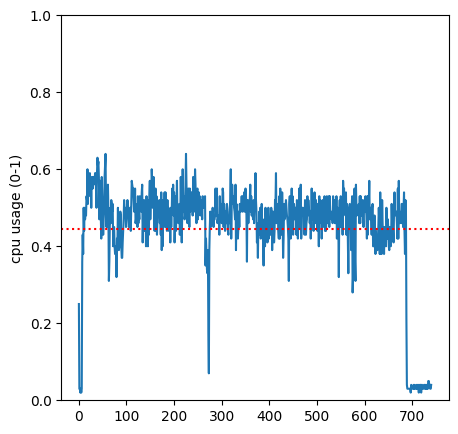

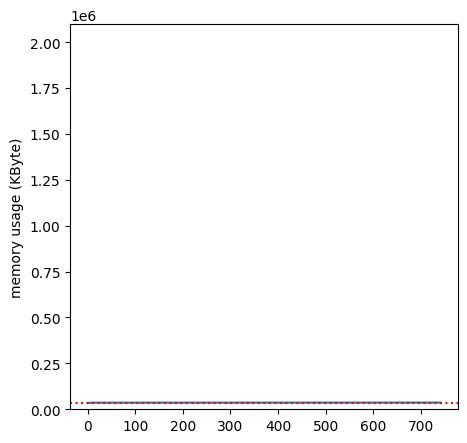

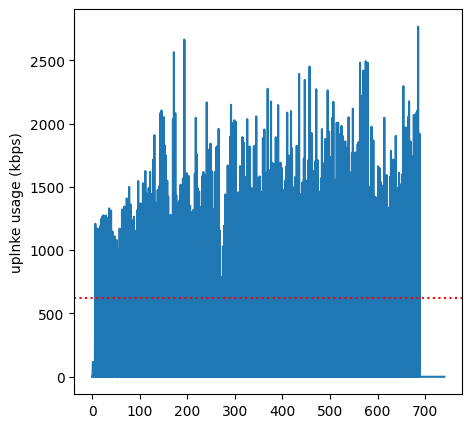

In [9]:
import matplotlib.pyplot as plt
import numpy as np

cpu_usage_set = cpu_usage_set[1:-1]
memory_usage_set = memory_usage_set[1:-1]
netword_up_set = netword_up_set[1:-1]

cpu_mean = np.mean(cpu_usage_set)
mem_mean = np.mean(memory_usage_set)
net_mean = np.mean(netword_up_set)

# 绘制cpu使用图
plt.figure(num=1, figsize=(5,5) )
plt.plot(cpu_usage_set)
plt.ylim((0,1))
plt.ylabel('cpu usage (0-1)')
plt.axhline(cpu_mean, color='red', linestyle=':')
plt.show()

# 绘制内存占用图
plt.figure(num=2, figsize=(5,5))
plt.plot(memory_usage_set)
plt.ylim((0,2048*1024))
plt.ylabel('memory usage (KByte)')
plt.axhline(mem_mean, color='red', linestyle=':')
plt.show()

# 绘制网络占用
plt.figure(num=3, figsize=(5,5))
plt.plot(netword_up_set)
plt.ylabel('uplnke usage (kbps)')
plt.axhline(net_mean, color='red', linestyle=':')
plt.show()

In [5]:
# 写入文件
import time 

cpu_filename = 'e:/cpu.txt'
mem_filename = 'e:/mem.txt'
upl_filename = 'e:/upl.txt'
with open(cpu_filename, 'a') as f:
    f.write(str(cpu_mean)+',')
    f.close()

with open(mem_filename, 'a') as f:
    f.write(str(mem_mean)+',')
    f.close()

with open(upl_filename, 'a') as f:
    f.write(str(net_mean)+',')
    f.close()
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime))

2023-05-11 10:16:57


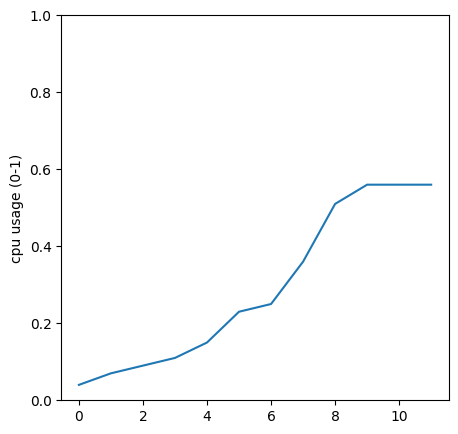

In [35]:
import numpy as np 

cpu_filename = 'e:/cpu.txt'
cpu_mean_list = []

with open(cpu_filename, 'r') as f:
    for line in f:
        cpu_mean_list = line.split(',')
    f.close()
    
cpu_mean_list = cpu_mean_list[0:len(cpu_mean_list)-1]
cpu_mean_list = [float(x) for x in cpu_mean_list]
cpu_mean_list = list(np.round(np.array(cpu_mean_list),2))

plt.figure(num=11, figsize=(5,5))
plt.plot(cpu_mean_list)
plt.ylim((0,1))
plt.ylabel('cpu usage (0-1)')
plt.show()

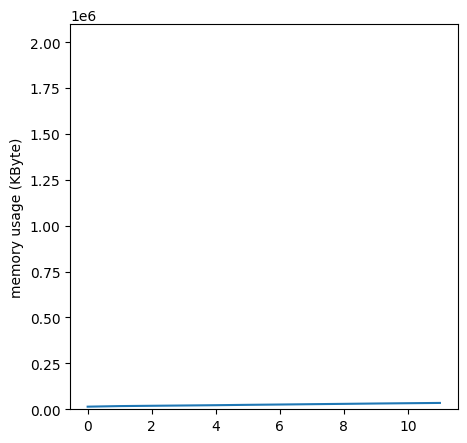

In [36]:
import numpy as np 

mem_filename = 'e:/mem.txt'
mme_mean_list = []

with open(mem_filename, 'r') as f:
    for line in f:
        mme_mean_list = line.split(',')
    f.close()
    
mme_mean_list = mme_mean_list[0:len(mme_mean_list)-1]
mme_mean_list = [float(x) for x in mme_mean_list]
mme_mean_list = list(np.round(np.array(mme_mean_list),2))

plt.figure(num=22, figsize=(5,5))
plt.plot(mme_mean_list)
plt.ylim((0,2048*1024))
plt.ylabel('memory usage (KByte)')
plt.show()


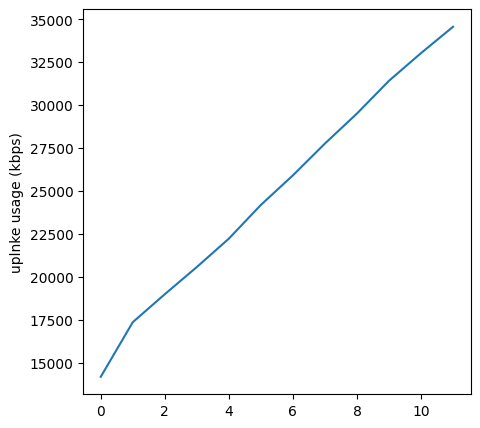

In [42]:
import numpy as np 

upl_filename = 'e:/upl.txt'
upl_mean_list = []

with open(upl_filename, 'r') as f:
    for line in f:
        upl_mean_list = line.split(',')
    f.close()
    
upl_mean_list = mme_mean_list[0:len(upl_mean_list)-1]
upl_mean_list = [float(x) for x in upl_mean_list]
upl_mean_list = list(np.round(np.array(upl_mean_list),2))

# 绘制网络占用
plt.figure(num=33, figsize=(5,5))
plt.plot(upl_mean_list)
plt.ylabel('uplnke usage (kbps)')
plt.show()

10 个推流线程 53%